# Text Classification
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. Please check the pdf file for more details.*

In this exercise you will:
    
- implement a of spam classifier with **Naive Bayes method** for real world email messages
- learn the **training and testing phase** for Naive Bayes classifier  
- get an idea of the **precision-recall** tradeoff

In [1]:
# some basic imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# ham_train contains the occurrences of each word in ham emails. 1-by-N vector
ham_train = np.loadtxt('ham_train.csv', delimiter=',')
# spam_train contains the occurrences of each word in spam emails. 1-by-N vector
spam_train = np.loadtxt('spam_train.csv', delimiter=',')
# N is the size of vocabulary.
N = ham_train.shape[0]
# There 9034 ham emails and 3372 spam emails in the training samples
num_ham_train = 9034
num_spam_train = 3372
# Do smoothing
x = np.vstack([ham_train, spam_train]) + 1
# ham_test contains the occurences of each word in each ham test email. P-by-N vector, with P is number of ham test emails.
i,j,ham_test = np.loadtxt('ham_test.txt').T
i = i.astype(np.int)
j = j.astype(np.int)
ham_test_tight = scipy.sparse.coo_matrix((ham_test, (i - 1, j - 1)))
ham_test = scipy.sparse.csr_matrix((ham_test_tight.shape[0], ham_train.shape[0]))
ham_test[:, 0:ham_test_tight.shape[1]] = ham_test_tight
# spam_test contains the occurences of each word in each spam test email. Q-by-N vector, with Q is number of spam test emails.
i,j,spam_test = np.loadtxt('spam_test.txt').T
i = i.astype(np.int)
j = j.astype(np.int)
spam_test_tight = scipy.sparse.csr_matrix((spam_test, (i - 1, j - 1)))
spam_test = scipy.sparse.csr_matrix((spam_test_tight.shape[0], spam_train.shape[0]))
spam_test[:, 0:spam_test_tight.shape[1]] = spam_test_tight


## Now let's implement a ham/spam email classifier. Please refer to the PDF file for details

In [3]:
from likelihood import likelihood
# TODO
# Implement a ham/spam email classifier, and calculate the accuracy of your classifier

# Hint: you can directly do matrix multiply between scipy.sparse.coo_matrix and numpy.array.
# Specifically, you can use sparse_matrix * np_array to do this. Note that when you use "*" operator
# between numpy array, this is typically an elementwise multiply.

# begin answer

## Question (a)

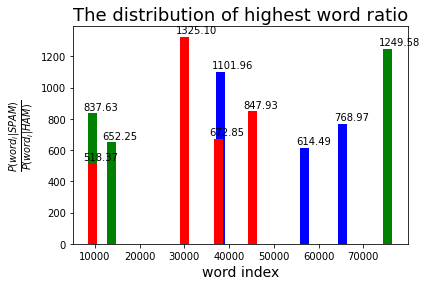

In [4]:
width = 2000
l = likelihood(x)
ratio = list(l[1] / l[0])
ratio_plt = ratio.copy()

# get the highest 10 words and their ratio percentages in these 2 lists
words = []
per = []

for i in range(10):
    per.append(max(ratio_plt))
    words.append(ratio_plt.index(max(ratio_plt)))
    ratio_plt[ratio_plt.index(max(ratio_plt))] = 0
p1 = plt.bar(words, per, width, color='rgb')
plt.xlabel('word index', fontsize=14)
plt.ylabel(r'$\frac{P(word_i|SPAM)}{P(word_i|HAM)}$', fontsize=14)
plt.title('The distribution of highest word ratio', fontsize=18)
for i in range(10):
    plt.text(words[i]-2000, per[i]+20, '%.2f'%per[i])
plt.show()

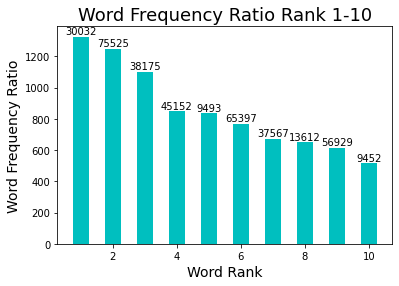

In [5]:
# Give a clear look of the rank of the distribution of highest frequency words
properties = list(zip(words, per))
properties = sorted(properties, key=lambda x:(x[1], x[0]), reverse=True)
properties = list(zip(*properties)) # unzip the properties to get 2 tuples [(words), (ratio)]
p2 = plt.bar([i for i in range(1, 11)], list(properties[1]), width=0.5, color='c')
for i in range(1, 11):
    plt.text(i, properties[1][i-1]+0.8, properties[0][i-1], ha='center', va='bottom')
plt.xlabel('Word Rank', fontsize=14)
plt.ylabel('Word Frequency Ratio', fontsize=14)
plt.title('Word Frequency Ratio Rank 1-10', fontsize=18)
plt.show()
# end answer

## Question (b)

In [9]:
# question (b) here establish a model using Naive Bayes Model to classify all the email into 2 classes, SPAM and HAM
import time

start = time.time()

# calculate the priori of 2 classes
p_w_spam = num_spam_train / (num_spam_train + num_ham_train)
p_w_ham = num_ham_train / (num_spam_train + num_ham_train)
total_test = spam_test.shape[1] + ham_test.shape[1]

error_ham2spam = 0  # error of making ham for spam
error_spam2ham = 0  # error of making spam for ham 

'''
Here is Function 1: using scipy sparse matrix to multiply numpy array to get the possibility
'''
# ratio = np.float64(ratio)
# for sample in ham_test:  # for every email in ham_test
#     sample = sample.astype(np.float64)
#     possibility = p_w_spam / p_w_ham
#     possibility *= np.prod(ratio ** sample.toarray())
#     if np.log(possibility) > 0:
#         error_ham2spam += 1

# for sample in spam_test:
#     sample = sample.astype(np.float64)
#     possibility = p_w_spam / p_w_ham
#     possibility *= np.prod(ratio ** sample.toarray())
#     if np.log(possibility) < 0:
#         error_spam2ham += 1


'''
Here is Function 2: take the position of every word in the matrix to multiply them one by one
'''
for sample in ham_test:    
    word_vec = [list(sample.indices), list(sample.data)]  # take every word's properties: [word_index, word_repeat_time]
    possibility = p_w_spam / p_w_ham  # initial possibility, equals to the ratio of priori of 2 classes
    for index in word_vec[0]:
        possibility *= ratio[index] ** int(word_vec[1][0])  # the repeat time works as an exponent
        del word_vec[1][0]  # make sure every time we take the next word's repeat time
    if np.log(possibility) > 0:
        error_ham2spam += 1

for sample in spam_test:
    word_vec = [list(sample.indices), list(sample.data)]
    possibility = p_w_spam / p_w_ham
    for index in word_vec[0]:
        possibility *= ratio[index] ** int(word_vec[1][0])
        del word_vec[1][0]
    if np.log(possibility) < 0:
        error_spam2ham += 1

accuracy = 1 - (error_ham2spam + error_spam2ham) / total_test  # calculate the overall accuracy. accuracy = TRUE_predicted / total_test_num

end = time.time()

print(f'Error of HAM -> SPAM is: {error_ham2spam}')
print(f'Error of SPAM -> HAM is: {error_spam2ham}')
print('Total accuracy is: {:.6f}%'.format(accuracy*100))
print('Time cost is: {:.3f}s'.format(end-start))


Error of HAM -> SPAM is: 28
Error of SPAM -> HAM is: 31
Total accuracy is: 99.961879%
Time cost is: 1.030s


## Question (d)

In [10]:
TP = spam_test.shape[1] - error_spam2ham
FN = error_spam2ham
TN = ham_test.shape[1] - error_ham2spam
FP = error_ham2spam
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('Precision is: {:.6f}%, Recall is: {:.6f}%'.format(precision*100, recall*100))

Precision is: 99.963816%, Recall is: 99.959941%
